In [45]:
# import dependencies
import os
import numpy as np
import matplotlib.pyplot as plt

from utils import load_config

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']
STORIES = cfg['STORIES']

subject = 'sub-UTS02'
story = 'treasureisland'

tr = 2

In [46]:
## prepare x and y data for regression
# load fsaverage data
from utils import load_surf, butterworth_highpass, zscore, load_mp3, get_envelope, lanczosinterp2D

surfdata = load_surf(DATADIR, subject, story)

# filtering
surf_zscored = zscore(butterworth_highpass(surfdata, tr, 0.01), axis=1)

# trim the first 5 and last 10 trs (following the Huth paper)
surf_trimmed = surf_zscored[:, 5:-10]
# surf_trimmed = surf_zscored

# auditory stimuli
audio, sr = load_mp3(STIMDIR, story)
audio_envelope = get_envelope(audio)

n_trs= surf_trimmed.shape[1]

# average envelope every 0.1 seconds
window = 0.1
audio_envelope_avg = np.mean(audio_envelope[:len(audio_envelope) // int(sr * window) * int(sr * window)].reshape(-1, int(sr * window)), axis=1).reshape(-1, 1)

dsEnv = lanczosinterp2D(audio_envelope_avg, np.arange(audio_envelope_avg.shape[0]) * window, np.arange(n_trs) * tr)

zEnv = zscore(dsEnv, axis=0)

zEnv = zEnv[7:]
surf_trimmed = surf_trimmed[:, :zEnv.shape[0]]


[25151, 33424, 11371, 16955, 2242, 29262, 29261, 25152, 369, 25148]


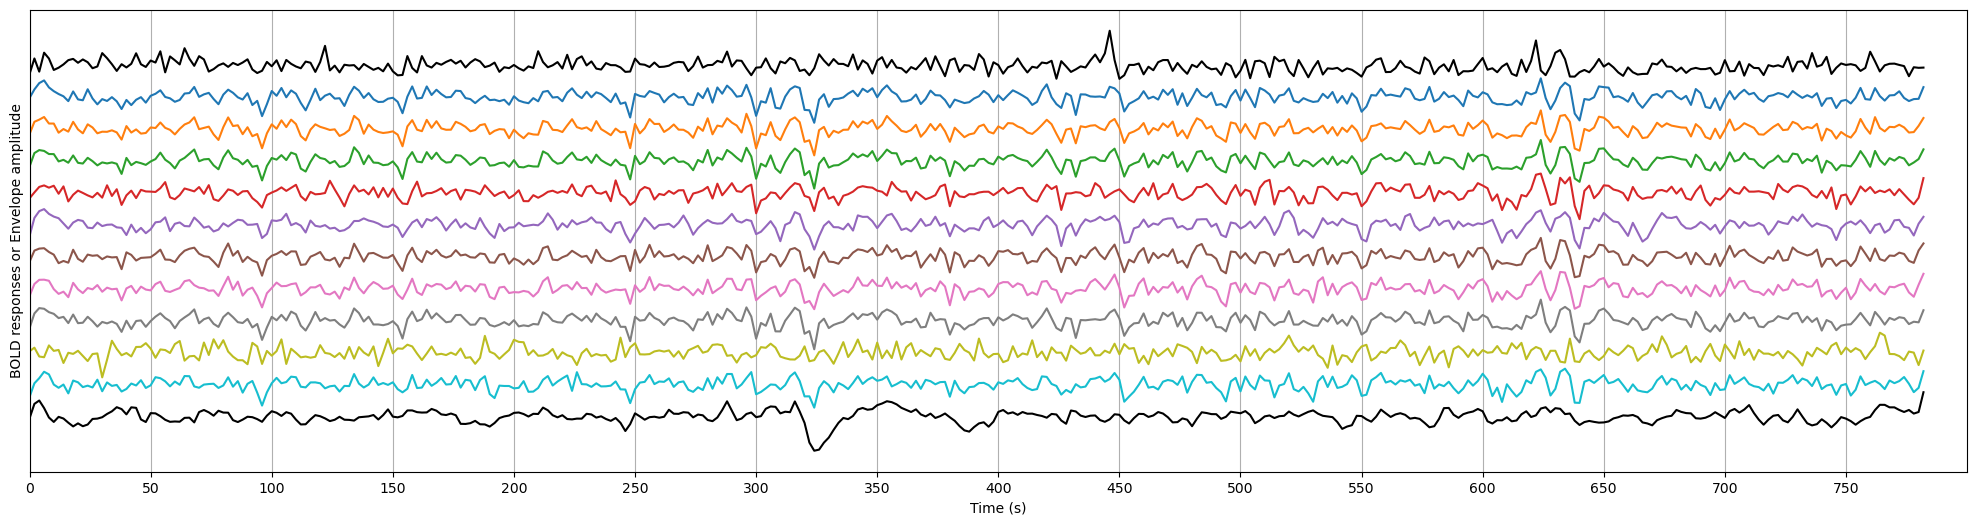

In [47]:
# plot the downsampled to 0.1s bin envelope, matched-to-TR envelope, and voxel data
from matplotlib.pyplot import figure
from nilearn import datasets
import nibabel as nib

# fsaverage dataset and labels
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')

# left hemisphere
surf_labels, ctab, surf_names = nib.freesurfer.read_annot('/Users/gio/Downloads/lh.Schaefer2018_200Parcels_17Networks_order.annot')
surf_labels = surf_labels.astype(int)
surf_names = [name.decode('utf-8') for name in surf_names]

aud_1_voxels = np.where(surf_labels == surf_names.index('17Networks_LH_SomMotB_Aud_1'))[0]

selvoxels = [1663, 16953, 11411, 11410, 3732, 25149, 269, 11412, 27369, 25150]
selvoxels = [25151, 33424, 11371, 16955, 2242, 29262, 29261, 25152, 369, 25148]
# np.random.seed(0)
# selvoxels = np.random.permutation(aud_1_voxels)[:10]
# selvoxels = np.random.randint(0, ydata.shape[1], 10)
print(selvoxels)

# ydata = surf_trimmed.T
ydata = surf_trimmed.T

colors = plt.cm.tab10.colors
f = figure(figsize=(25,6))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(np.arange(zEnv.shape[0]) * tr, zEnv + 5, "k-", label="Downsampled envelope (TR)")
for i, voxel in enumerate(selvoxels):
    ax.plot(np.arange(ydata.shape[0]) * tr, ydata[:, voxel] - i * 5, label=f"Voxel {voxel}", color=colors[i])

ax.plot(np.arange(ydata.shape[0]) * tr, zscore(np.mean(ydata, axis=1)) - 50, label=f"Voxel {voxel}", color='k')


ax.set_xlim(0, 800)
ax.set_xticks(range(0, 800, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()


-1


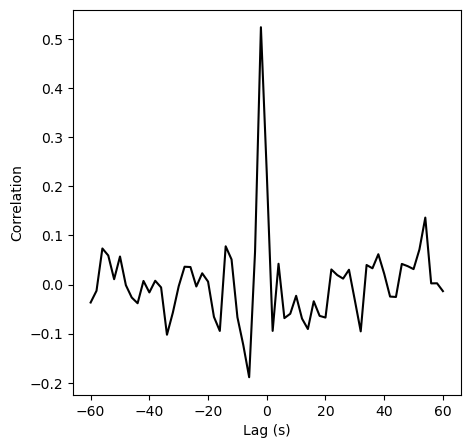

In [52]:
# compute lag cross correlation between two time series
from scipy.signal import correlate
from scipy.stats import zscore

def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

# compute lag cross correlation between the envelope and the first selvoxels
v1 = np.squeeze(ydata[:, selvoxels[1]])

lags, corrs = lagcorr(np.squeeze(zEnv), v1, maxlag=30)

f = figure(figsize=(5,5))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(lags * tr, corrs, "k-")
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")

print(lags[np.argmax(corrs)])


In [49]:
# build auditory encoding model for the huth dataset
from utils import make_delayed, pearsonr
from ridge import bootstrap_ridge

n_delays = 4 # 8 seconds
xdata = make_delayed(zEnv, np.arange(1, n_delays + 1))

alphas = np.logspace(-3, 3, 7)
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

n_voxels = ydata.shape[1]

permuted_idx = np.random.permutation(ydata.shape[0])
test_idx = permuted_idx[:ydata.shape[0] // 5]
train_idx = permuted_idx[ydata.shape[0] // 5:]
delRstim = xdata[train_idx, :]
delPstim = xdata[test_idx, :]
delRresp = ydata[train_idx, :]
delPresp = ydata[test_idx, :]

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, delRresp, delPstim, delPresp, alphas, nboots, chunklen, nchunks, singcutoff=1e-10, single_alpha=True)

pred = np.dot(delPstim, wt)

voxcorrs = pearsonr(pred, delPresp)

[16955 33414 16953  1663 10771 16962  1637 25074 16954  3690]
[16960 25149  3732 12639 33415 25150 25075 25073 11411 12637]


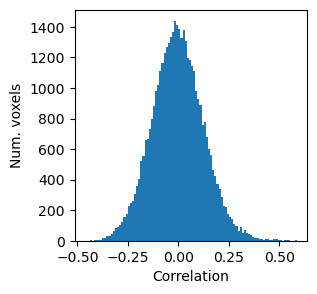

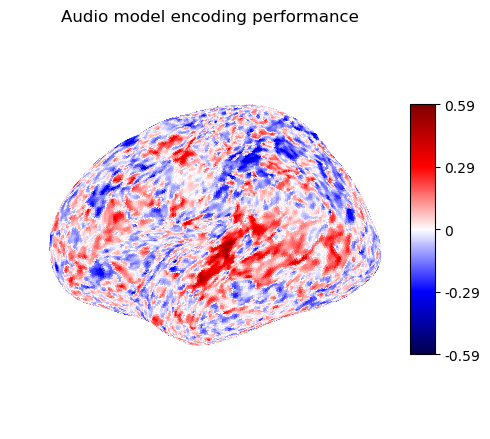

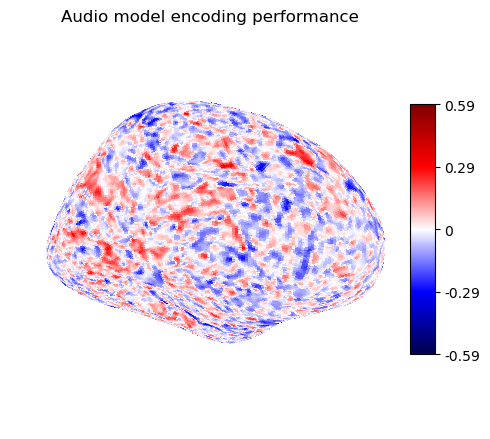

In [50]:
# Plot histogram of correlations
sorted_voxels = np.argsort(voxcorrs)[::-1]
print(sorted_voxels[:10])
print(sorted_voxels[10:20])
f = figure(figsize=(3,3))
ax = f.add_subplot(1,1,1)
ax.hist(voxcorrs, 100) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. voxels")


# plot surface map
from nilearn import plotting, datasets

fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage6")

fig = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, title='Audio model encoding performance', cmap='seismic')

fig = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, title='Audio model encoding performance', cmap='seismic')